In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import warnings
warnings.filterwarnings('ignore')
import pickle
import time
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve
import anndata
import scanpy as sc
import torch
from torch import nn, Tensor
from scfoundation import load

In [2]:
class SlideData():
    def __init__(self, data_path, slide, label_path, pad_value, pad_token):
        self.data_path = data_path
        self.slide = slide
        self.label_path = label_path
        self.pad_value = pad_value
        self.pad_token = pad_token
        self.load_data()

    def load_data(self):
        adata = sc.read_h5ad(f'{self.data_path}/{self.slide}_Visium_deconv.h5ad')
        
        scfoundation_gene_df = pd.read_csv(f'{tokenizer_dir}/scfoundation_gene_df.csv')
        scfoundation_gene_df.set_index('gene_ids', inplace=True)
        total_gene_num = adata.shape[1]
        adata = adata[:, adata.var_names.isin(scfoundation_gene_df.index)]
        adata.var['gene_name'] = scfoundation_gene_df.loc[adata.var_names, 'gene_symbols'].values
        seleted_gene_num = adata.shape[1]

        print(
            f"match {seleted_gene_num}/{total_gene_num} genes "
            f"in vocabulary of size 19264."
        )

        for celltype in adata.layers.keys():
            adata.X = adata.layers[celltype]
            sc.pp.normalize_total(adata, target_sum=1e4)
            sc.pp.log1p(adata)
            adata.uns.pop('log1p')
            adata.layers[celltype] = adata.X

        celltype_proportion = adata.obsm['q05_cell_abundance_w_sf']
        celltype_proportion.rename(columns=lambda x: x[23:], inplace=True)
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)
        celltype_proportion[celltype_proportion < 0.05] = 0
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)

        self.adata = adata
        self.celltype_proportion = celltype_proportion

    def get_sc_data(self):
        barcode_list = []
        gexpr_feature = []
        celltypes_labels = []
        for i in range(self.adata.shape[0]):
            barcode = self.adata.obs.index[i]
            ct_prop = self.celltype_proportion.iloc[i][self.celltype_proportion.iloc[i]>0]
            cell_num = 0
            for ct in ct_prop.index:
                celltypes_labels.append(ct)
                cell_num += 1
                barcode_list.append(f'{barcode}_{cell_num}')
                gexpr_feature.append(self.adata.layers[ct][i].A)
        gexpr_feature = np.concatenate(gexpr_feature)

        adata_sc = anndata.AnnData(X=gexpr_feature, obs=pd.DataFrame({'celltype': celltypes_labels}, index=barcode_list), var=pd.DataFrame({'gene_name': self.adata.var['gene_name'].values}, index=self.adata.var_names.values), obsm=None)
        self.adata = adata_sc

    def prepare_data(self):
        gene_list_df = pd.read_csv(f'{tokenizer_dir}/OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
        gene_list = list(gene_list_df['gene_name'])
        gene_list_df.set_index('gene_name', inplace=True)

        gexpr_feature = self.adata.X
        idx = self.adata.obs_names.tolist()
        col = self.adata.var.gene_name.tolist()
        gexpr_feature = pd.DataFrame(gexpr_feature, index=idx, columns=col)
        gexpr_feature, _ = load.main_gene_selection(gexpr_feature, gene_list)
        S = gexpr_feature.sum(1)
        T = S
        TS = np.concatenate([[np.log10(T)],[np.log10(S)]],axis=0).T
        data = np.concatenate([gexpr_feature,TS],axis=1)
        self.data = data

        df_label = pd.read_csv(f'{self.label_path}', header=0)
        df_label = df_label[df_label['gene_ids'].isin(self.adata.var_names)]
        gene_targets = self.adata.var.loc[df_label['gene_ids'],'gene_name'].values
        gene_targets = gene_list_df.loc[gene_targets,'index'].values
        gene_labels = df_label['label'].values
        gene2label = dict(zip(gene_targets, gene_labels))
        for g in gene_list_df['index'].values:
            if g not in gene2label:
                gene2label[g] = -100
        gene2label[19264] = gene2label[19265] = gene2label[19266] = -100
        
        self.gene2label = gene2label
        self.gene_targets = gene_targets
        self.gene_labels = gene_labels

    def prepare_train_and_valid_data(self, train_index, valid_index):
        gene_targets_train = self.gene_targets[train_index]
        gene_targets_valid = self.gene_targets[valid_index]

        gene2label_train = self.gene2label.copy()
        for gene in gene2label_train:
            if gene not in gene_targets_train:
                gene2label_train[gene] = -100
        gene2label_valid = self.gene2label.copy()
        for gene in gene2label_valid:
            if gene not in gene_targets_valid:
                gene2label_valid[gene] = -100

        data = self.data
        train_data = [d for d in data if len(set(np.nonzero(d)[0]).intersection(set(gene_targets_train)))>0]
        valid_data = [d for d in data if len(set(np.nonzero(d)[0]).intersection(set(gene_targets_valid)))>0]
        train_data = torch.from_numpy(np.array(train_data)).float()
        valid_data = torch.from_numpy(np.array(valid_data)).float()
        train_data_gene_ids = torch.arange(train_data.shape[1]).repeat(train_data.shape[0], 1)
        valid_data_gene_ids = torch.arange(valid_data.shape[1]).repeat(valid_data.shape[0], 1)

        train_data_index = train_data != 0
        train_values, train_padding = load.gatherData(train_data, train_data_index, self.pad_value)
        train_gene_ids, _ = load.gatherData(train_data_gene_ids, train_data_index, self.pad_token)
        train_gene_labels = torch.from_numpy(np.vectorize(gene2label_train.get)(train_gene_ids.numpy()))
        train_data = {'values': train_values, 'padding': train_padding, 'gene_ids': train_gene_ids, 'gene_labels': train_gene_labels}

        valid_data_index = valid_data != 0
        valid_values, valid_padding = load.gatherData(valid_data, valid_data_index, self.pad_value)
        valid_gene_ids, _ = load.gatherData(valid_data_gene_ids, valid_data_index, self.pad_token)
        valid_gene_labels = torch.from_numpy(np.vectorize(gene2label_valid.get)(valid_gene_ids.numpy()))
        valid_data = {'values': valid_values, 'padding': valid_padding, 'gene_ids': valid_gene_ids, 'gene_labels': valid_gene_labels}

        return train_data, valid_data

In [3]:
class scF_Gcl(nn.Module):
    def __init__(
            self,
            scf_token_emb,
            scf_pos_emb,
            scf_encoder,
            d_model: int,
            n_gcl: int = 2,
            nlayers_gcl: int = 3,
    ):
        super(scF_Gcl, self).__init__()

        # encoder
        self.token_emb = scf_token_emb
        self.pos_emb = scf_pos_emb
        self.encoder = scf_encoder
        self.gcl_decoder = GclDecoder(d_model, n_gcl, nlayers=nlayers_gcl)

    def forward(self, gene_values, padding_label, gene_ids):

        # token and positional embedding
        x = self.token_emb(torch.unsqueeze(gene_values, 2), output_weight = 0)

        position_emb = self.pos_emb(gene_ids)
        x += position_emb
        x = self.encoder(x, padding_mask=padding_label)
        output = self.gcl_decoder(x)

        return output


class GclDecoder(nn.Module):
    """
    Decoder for gene classification task.
    """

    def __init__(
        self,
        d_model: int,
        n_gcl: int,
        nlayers: int = 3,
        activation: callable = nn.ReLU,
    ):
        super().__init__()
        # module list
        self._decoder = nn.ModuleList()
        for i in range(nlayers - 1):
            self._decoder.append(nn.Linear(d_model, d_model))
            self._decoder.append(activation())
            self._decoder.append(nn.LayerNorm(d_model))
        self.out_layer = nn.Linear(d_model, n_gcl)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embsize]
        """
        for layer in self._decoder:
            x = layer(x)
        return self.out_layer(x)

In [4]:
criterion_cls = nn.CrossEntropyLoss()

def train(model: nn.Module, train_data ,valid_data, batch_size, max_batch) -> None:
    """
    Train the model for one epoch.
    """
    lr = 1e-4
    amp = True
    schedule_ratio = 0.9
    schedule_interval = 1
    log_interval = 10

    optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, eps=1e-4 if amp else 1e-8
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, schedule_interval, gamma=schedule_ratio
    )
    scaler = torch.cuda.amp.GradScaler(enabled=amp)

    model.train()
    total_gcl = 0.0
    total_error = 0.0
    
    best_val_auc = 0
    best_fpr = 0
    best_tpr = 0
    best_model = None

    start_time = time.time()

    train_values = train_data['values']
    train_padding = train_data['padding']
    train_gene_ids = train_data['gene_ids']
    train_gene_labels = train_data['gene_labels']

    num_batches = np.ceil(len(train_values)/batch_size).astype(int)
    for k in range(0, len(train_values), batch_size):
        batch = int(k/batch_size+1)
        if batch > max_batch:
            break
        with torch.cuda.amp.autocast(enabled=amp):
            output = model(train_values[k:k+batch_size].to(device), 
                           train_padding[k:k+batch_size].to(device), 
                           train_gene_ids[k:k+batch_size].to(device))
            
            batch_train_gene_labels = train_gene_labels[k:k+batch_size].to(device)
            batch_logits = output[torch.logical_or(batch_train_gene_labels==1, batch_train_gene_labels==0)]
            batch_labels = batch_train_gene_labels[torch.logical_or(batch_train_gene_labels==1, batch_train_gene_labels==0)]
            targets = train_gene_ids[k:k+batch_size].to(device)[torch.logical_or(batch_train_gene_labels==1, batch_train_gene_labels==0)]
            loss_gcl = 0.0
            for t in set(targets):
                loss_gcl += criterion_cls(batch_logits[targets==t], batch_labels[targets==t])
            loss_gcl = loss_gcl/len(set(targets))

            error_rate_gcl = 1 - (
                    (batch_logits.argmax(1) == batch_labels)
                    .sum()
                    .item()
                ) / batch_labels.size(0)
            
        model.zero_grad()
        scaler.scale(loss_gcl).backward()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()

        total_gcl += loss_gcl.item()
        total_error += error_rate_gcl
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            sec_per_batch = (time.time() - start_time) / log_interval
            cur_gcl = total_gcl / log_interval
            cur_error = total_error / log_interval
            print(f"| Split {split} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.8f} | sec/batch {sec_per_batch:5.1f} | "
                f"gcl {cur_gcl:5.5f} | "
                f"err {cur_error:1.5f} | "
            )
            total_gcl = 0
            total_error = 0
            start_time = time.time()
        if batch % (10*log_interval) == 0 and batch > 0:   
            val_auc, fpr, tpr  = evaluate(model, valid_data, batch_size)
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_fpr = fpr
                best_tpr = tpr
                best_model = copy.deepcopy(model)
            model.train()
            start_time = time.time()

    interp_tpr = np.interp(mean_fpr, best_fpr, best_tpr)
    interp_tpr[0] = 0.0
    return best_model, interp_tpr, best_fpr, best_tpr

def py_softmax(vector):
	e = np.exp(vector)
	return e / e.sum()

def evaluate(model: nn.Module, valid_data, batch_size) -> None:
    amp = True
    
    model.eval()
    total_gcl = 0.0
    total_error = 0.0
    total_num = 0
    
    logits = []
    labels = []

    valid_values = valid_data['values']
    valid_padding = valid_data['padding']
    valid_gene_ids = valid_data['gene_ids']
    valid_gene_labels = valid_data['gene_labels']

    with torch.no_grad():
        for k in tqdm(range(0, len(valid_values), batch_size)):
            # if k>100*batch_size:
            #     break
            with torch.cuda.amp.autocast(enabled=amp):
                output = model(valid_values[k:k+batch_size].to(device), 
                           valid_padding[k:k+batch_size].to(device), 
                           valid_gene_ids[k:k+batch_size].to(device))
            
                batch_valid_gene_labels = valid_gene_labels[k:k+batch_size].to(device)
                batch_logits = output[torch.logical_or(batch_valid_gene_labels==1, batch_valid_gene_labels==0)]
                batch_labels = batch_valid_gene_labels[torch.logical_or(batch_valid_gene_labels==1, batch_valid_gene_labels==0)]
                logits.append(batch_logits.to('cpu'))
                labels.append(batch_labels.to('cpu'))
            
            accuracy = (batch_logits.argmax(1) == batch_labels).sum().item()
            total_error += batch_labels.size(0) - accuracy
            total_num += batch_labels.size(0)
            total_gcl += criterion_cls(batch_logits, batch_labels).item()*batch_labels.size(0) 

    logits = torch.concat(logits).float()
    labels = torch.concat(labels)

    y_score = [py_softmax(item)[1] for item in logits.numpy()]
    y_true = labels.numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_value = auc(fpr, tpr)

    val_err = total_error / total_num
    val_loss = total_gcl / total_num
    print("-" * 89)
    print(
        f"valid accuracy: {1-val_err:1.4f} | "
        f"valid auc: {auc_value:1.4f} | "
        f"valid loss: {val_loss:1.4f} | "
        f"valid err: {val_err:1.4f}"
    )
    print("-" * 89)
    return auc_value, fpr, tpr


def train_and_evaluate(model, train_data, valid_data, batch_size, max_batch):

    best_model, interp_tpr, best_fpr, best_tpr = train(model, train_data, valid_data, batch_size, max_batch)
    
    return best_model, interp_tpr, best_fpr, best_tpr

In [5]:
class scFoundation(nn.Module):
    def __init__(
            self,
            scf_token_emb,
            scf_pos_emb,
            scf_encoder,
            scf_decoder,
            scf_decoder_embed,
            scf_norm,
            scf_to_final,
    ):
        super(scFoundation, self).__init__()

        # encoder
        self.token_emb = scf_token_emb
        self.pos_emb = scf_pos_emb

        # ## DEBUG
        self.encoder = scf_encoder

        ##### decoder
        self.decoder = scf_decoder
        self.decoder_embed = scf_decoder_embed
        self.norm = scf_norm
        self.to_final = scf_to_final

    def forward(self, x, padding_label, encoder_position_gene_ids, encoder_labels, decoder_data,
                decoder_position_gene_ids, decoder_data_padding_labels, **kwargs):

        # token and positional embedding
        x = self.token_emb(torch.unsqueeze(x, 2), output_weight = 0)

        position_emb = self.pos_emb(encoder_position_gene_ids)
        x += position_emb
        x = self.encoder(x, padding_mask=padding_label)

        decoder_data = self.token_emb(torch.unsqueeze(decoder_data, 2))
        position_emb = self.pos_emb(decoder_position_gene_ids)
        batch_idx, gen_idx = (encoder_labels == True).nonzero(as_tuple=True)
        decoder_data[batch_idx, gen_idx] = x[~padding_label].to(decoder_data.dtype)

        decoder_data += position_emb

        decoder_data = self.decoder_embed(decoder_data)
        x = self.decoder(decoder_data, padding_mask=decoder_data_padding_labels)

        x = self.norm(x)
        # return x
        x = self.to_final(x)
        return x.squeeze(2)

In [6]:
def initialize_model(model_file):
    if model_file is None:
        # load pretrained model
        pretrainmodel, pretrainconfig = load.load_model_frommmf('scfoundation/models/models.ckpt')
    else:
        # load fine-tuned model
        pretrainmodel = torch.load(f'scfoundation/fine-tuning/{model_file}', map_location='cpu')
        pretrainmodel = pretrainmodel.module
    
    model = scF_Gcl(pretrainmodel.token_emb,
            pretrainmodel.pos_emb,
            pretrainmodel.encoder,
            d_model = 768,
            n_gcl = 2,
            nlayers_gcl = 3
            )
    
    pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())
    for name, para in model.named_parameters():
            para.requires_grad = False
    for name, para in model.gcl_decoder.named_parameters():
            para.requires_grad = True
    post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())
    print(f"Total Pre freeze Params {(pre_freeze_param_count )}")
    print(f"Total Post freeze Params {(post_freeze_param_count )}")

    return model

In [7]:
pad_token = 19266
pad_value = 103
tokenizer_dir = '/home/shcao/spFormer/spformer/tokenizer/'

In [8]:
model_file = 'model_human_myocardial_infarction.ckpt' # None

dataset = 'human_myocardial_infarction_dataset'
slide = 'ACH005'
data_path = f'data/{dataset}/'
label_path = f'gene_lists/signaling_by_TGFB_family_members_REACTOME.csv' # n1_network_gene_labels.csv or n1_target_gene_labels.csv
slideData = SlideData(data_path, slide, label_path, pad_value, pad_token)
slideData.get_sc_data()
slideData.prepare_data()

batch_size = 24
max_batch = 500

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
all_roc_auc = []
all_tpr_wt = []

split = 0
for train_index, valid_index in skf.split(slideData.gene_targets, slideData.gene_labels):
    split += 1
    print(f"Cross-validate on dataset {dataset} slide {slide} - split {split}")
    train_data, valid_data = slideData.prepare_train_and_valid_data(train_index, valid_index)

    model = initialize_model(model_file)
    model = torch.nn.DataParallel(model, device_ids=[1, 3, 0])
    device = torch.device("cuda:1")
    model.to(device)

    best_model, interp_tpr, best_fpr, best_tpr = train_and_evaluate(model, train_data, valid_data, batch_size, max_batch)
    all_tpr.append(interp_tpr)
    all_roc_auc.append(auc(best_fpr, best_tpr))
    all_tpr_wt.append(len(best_tpr))

match 11458/12445 genes in vocabulary of size 19264.
Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 1
Total Pre freeze Params 101127486
Total Post freeze Params 1185794
| Split 1 |  10/547 batches | lr 0.00010000 | sec/batch   1.0 | gcl 0.68564 | err 0.39261 | 
| Split 1 |  20/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.67038 | err 0.39506 | 
| Split 1 |  30/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.64312 | err 0.38499 | 
| Split 1 |  40/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62603 | err 0.36861 | 
| Split 1 |  50/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.63266 | err 0.37459 | 
| Split 1 |  60/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.64044 | err 0.38912 | 
| Split 1 |  70/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62665 | err 0.36510 | 
| Split 1 |  80/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62764 | err 0.37544 | 
| Split 1 |  90/547 batches | lr 0.00010000 | sec/batch   0

100%|██████████| 545/545 [03:50<00:00,  2.37it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6555 | valid auc: 0.7180 | valid loss: 0.5788 | valid err: 0.3445
-----------------------------------------------------------------------------------------
| Split 1 | 110/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61494 | err 0.35713 | 
| Split 1 | 120/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61143 | err 0.35339 | 
| Split 1 | 130/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60684 | err 0.34774 | 
| Split 1 | 140/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61142 | err 0.35666 | 
| Split 1 | 150/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60618 | err 0.35315 | 
| Split 1 | 160/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61226 | err 0.35862 | 
| Split 1 | 170/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60370 | err 0.34099 | 
| Split 1 | 180/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60346 | err 0.3

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6700 | valid auc: 0.7086 | valid loss: 0.5915 | valid err: 0.3300
-----------------------------------------------------------------------------------------
| Split 1 | 210/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59354 | err 0.34144 | 
| Split 1 | 220/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60978 | err 0.35923 | 
| Split 1 | 230/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58880 | err 0.33905 | 
| Split 1 | 240/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60636 | err 0.35401 | 
| Split 1 | 250/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61937 | err 0.36784 | 
| Split 1 | 260/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61634 | err 0.36391 | 
| Split 1 | 270/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58654 | err 0.33899 | 
| Split 1 | 280/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58891 | err 0.3

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6755 | valid auc: 0.7141 | valid loss: 0.5698 | valid err: 0.3245
-----------------------------------------------------------------------------------------
| Split 1 | 310/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57606 | err 0.32797 | 
| Split 1 | 320/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58198 | err 0.33764 | 
| Split 1 | 330/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58249 | err 0.33964 | 
| Split 1 | 340/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58146 | err 0.33023 | 
| Split 1 | 350/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59268 | err 0.34518 | 
| Split 1 | 360/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58418 | err 0.33392 | 
| Split 1 | 370/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58746 | err 0.34010 | 
| Split 1 | 380/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57315 | err 0.3

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6599 | valid auc: 0.7089 | valid loss: 0.5833 | valid err: 0.3401
-----------------------------------------------------------------------------------------
| Split 1 | 410/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57306 | err 0.32794 | 
| Split 1 | 420/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56231 | err 0.32295 | 
| Split 1 | 430/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57573 | err 0.33155 | 
| Split 1 | 440/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57411 | err 0.32949 | 
| Split 1 | 450/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56448 | err 0.32662 | 
| Split 1 | 460/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57866 | err 0.33565 | 
| Split 1 | 470/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55603 | err 0.30771 | 
| Split 1 | 480/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55779 | err 0.3

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6241 | valid auc: 0.6705 | valid loss: 0.6339 | valid err: 0.3759
-----------------------------------------------------------------------------------------
Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 2
Total Pre freeze Params 101127486
Total Post freeze Params 1185794
| Split 2 |  10/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.67942 | err 0.38461 | 
| Split 2 |  20/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.63348 | err 0.36866 | 
| Split 2 |  30/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61053 | err 0.35419 | 
| Split 2 |  40/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60609 | err 0.35155 | 
| Split 2 |  50/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60209 | err 0.34170 | 
| Split 2 |  60/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62147 | err 0.36121 | 
| Split 2 |  70/547 batches | lr 0

100%|██████████| 544/544 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5687 | valid auc: 0.6034 | valid loss: 0.6911 | valid err: 0.4313
-----------------------------------------------------------------------------------------
| Split 2 | 110/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58321 | err 0.33365 | 
| Split 2 | 120/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.58763 | err 0.33863 | 
| Split 2 | 130/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57271 | err 0.32436 | 
| Split 2 | 140/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58300 | err 0.32598 | 
| Split 2 | 150/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58371 | err 0.33002 | 
| Split 2 | 160/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.58611 | err 0.33218 | 
| Split 2 | 170/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56761 | err 0.32149 | 
| Split 2 | 180/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57326 | err 0.3

100%|██████████| 544/544 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5736 | valid auc: 0.6043 | valid loss: 0.6914 | valid err: 0.4264
-----------------------------------------------------------------------------------------
| Split 2 | 210/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56629 | err 0.32186 | 
| Split 2 | 220/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.58510 | err 0.33561 | 
| Split 2 | 230/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55856 | err 0.31287 | 
| Split 2 | 240/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.58592 | err 0.33933 | 
| Split 2 | 250/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.59191 | err 0.33414 | 
| Split 2 | 260/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58907 | err 0.33115 | 
| Split 2 | 270/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55134 | err 0.30324 | 
| Split 2 | 280/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56892 | err 0.3

100%|██████████| 544/544 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5673 | valid auc: 0.6032 | valid loss: 0.7052 | valid err: 0.4327
-----------------------------------------------------------------------------------------
| Split 2 | 310/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56027 | err 0.31842 | 
| Split 2 | 320/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.55320 | err 0.30776 | 
| Split 2 | 330/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56195 | err 0.31660 | 
| Split 2 | 340/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.55629 | err 0.30832 | 
| Split 2 | 350/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56023 | err 0.31494 | 
| Split 2 | 360/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56326 | err 0.31690 | 
| Split 2 | 370/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56059 | err 0.31649 | 
| Split 2 | 380/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.54189 | err 0.3

100%|██████████| 544/544 [03:49<00:00,  2.37it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5560 | valid auc: 0.5910 | valid loss: 0.7303 | valid err: 0.4440
-----------------------------------------------------------------------------------------
| Split 2 | 410/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.54730 | err 0.31353 | 
| Split 2 | 420/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.54656 | err 0.31110 | 
| Split 2 | 430/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.53954 | err 0.30197 | 
| Split 2 | 440/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.53371 | err 0.28961 | 
| Split 2 | 450/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.54448 | err 0.30835 | 
| Split 2 | 460/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.54498 | err 0.30217 | 
| Split 2 | 470/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.53757 | err 0.30032 | 
| Split 2 | 480/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.52962 | err 0.2

100%|██████████| 544/544 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5689 | valid auc: 0.5870 | valid loss: 0.7229 | valid err: 0.4311
-----------------------------------------------------------------------------------------
Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 3
Total Pre freeze Params 101127486
Total Post freeze Params 1185794
| Split 3 |  10/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.72939 | err 0.41191 | 
| Split 3 |  20/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.68355 | err 0.40247 | 
| Split 3 |  30/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.63963 | err 0.38032 | 
| Split 3 |  40/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.63312 | err 0.36868 | 
| Split 3 |  50/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.63154 | err 0.37690 | 
| Split 3 |  60/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.65211 | err 0.40116 | 
| Split 3 |  70/547 batches | lr 0

100%|██████████| 546/546 [03:51<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6975 | valid auc: 0.7734 | valid loss: 0.5426 | valid err: 0.3025
-----------------------------------------------------------------------------------------
| Split 3 | 110/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61629 | err 0.36383 | 
| Split 3 | 120/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.61583 | err 0.35816 | 
| Split 3 | 130/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61076 | err 0.35509 | 
| Split 3 | 140/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61400 | err 0.35175 | 
| Split 3 | 150/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62035 | err 0.36561 | 
| Split 3 | 160/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62154 | err 0.36642 | 
| Split 3 | 170/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60712 | err 0.35634 | 
| Split 3 | 180/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61160 | err 0.3

100%|██████████| 546/546 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.7045 | valid auc: 0.7750 | valid loss: 0.5551 | valid err: 0.2955
-----------------------------------------------------------------------------------------
| Split 3 | 210/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60488 | err 0.35561 | 
| Split 3 | 220/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61857 | err 0.37070 | 
| Split 3 | 230/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58991 | err 0.33973 | 
| Split 3 | 240/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61462 | err 0.36607 | 
| Split 3 | 250/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61946 | err 0.36658 | 
| Split 3 | 260/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62652 | err 0.37246 | 
| Split 3 | 270/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59778 | err 0.34782 | 
| Split 3 | 280/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60813 | err 0.3

100%|██████████| 546/546 [03:51<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.7191 | valid auc: 0.7706 | valid loss: 0.5522 | valid err: 0.2809
-----------------------------------------------------------------------------------------
| Split 3 | 310/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.59957 | err 0.35135 | 
| Split 3 | 320/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60300 | err 0.35650 | 
| Split 3 | 330/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59312 | err 0.34636 | 
| Split 3 | 340/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58996 | err 0.33946 | 
| Split 3 | 350/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58922 | err 0.34269 | 
| Split 3 | 360/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59814 | err 0.34775 | 
| Split 3 | 370/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59593 | err 0.34777 | 
| Split 3 | 380/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58163 | err 0.3

100%|██████████| 546/546 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6858 | valid auc: 0.7720 | valid loss: 0.5530 | valid err: 0.3142
-----------------------------------------------------------------------------------------
| Split 3 | 410/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57595 | err 0.32891 | 
| Split 3 | 420/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58224 | err 0.34235 | 
| Split 3 | 430/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57553 | err 0.33301 | 
| Split 3 | 440/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57288 | err 0.32848 | 
| Split 3 | 450/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56100 | err 0.31940 | 
| Split 3 | 460/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57648 | err 0.33373 | 
| Split 3 | 470/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56413 | err 0.32237 | 
| Split 3 | 480/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56506 | err 0.3

100%|██████████| 546/546 [03:50<00:00,  2.37it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6767 | valid auc: 0.7380 | valid loss: 0.5898 | valid err: 0.3233
-----------------------------------------------------------------------------------------
Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 4
Total Pre freeze Params 101127486
Total Post freeze Params 1185794
| Split 4 |  10/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.69158 | err 0.39467 | 
| Split 4 |  20/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.67217 | err 0.38502 | 
| Split 4 |  30/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.63825 | err 0.36495 | 
| Split 4 |  40/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62316 | err 0.36925 | 
| Split 4 |  50/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62908 | err 0.37184 | 
| Split 4 |  60/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.64649 | err 0.39382 | 
| Split 4 |  70/547 batches | lr 0

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6411 | valid auc: 0.6924 | valid loss: 0.6179 | valid err: 0.3589
-----------------------------------------------------------------------------------------
| Split 4 | 110/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60465 | err 0.34642 | 
| Split 4 | 120/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.60392 | err 0.35460 | 
| Split 4 | 130/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59888 | err 0.33789 | 
| Split 4 | 140/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60065 | err 0.34050 | 
| Split 4 | 150/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59727 | err 0.33783 | 
| Split 4 | 160/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60767 | err 0.34672 | 
| Split 4 | 170/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59148 | err 0.33511 | 
| Split 4 | 180/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59730 | err 0.3

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6539 | valid auc: 0.6998 | valid loss: 0.6089 | valid err: 0.3461
-----------------------------------------------------------------------------------------
| Split 4 | 210/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58292 | err 0.32891 | 
| Split 4 | 220/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.60881 | err 0.36193 | 
| Split 4 | 230/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58754 | err 0.32973 | 
| Split 4 | 240/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61903 | err 0.35695 | 
| Split 4 | 250/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60415 | err 0.34941 | 
| Split 4 | 260/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.60595 | err 0.34646 | 
| Split 4 | 270/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58737 | err 0.33865 | 
| Split 4 | 280/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59398 | err 0.3

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6525 | valid auc: 0.7025 | valid loss: 0.6015 | valid err: 0.3475
-----------------------------------------------------------------------------------------
| Split 4 | 310/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.58958 | err 0.34236 | 
| Split 4 | 320/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57868 | err 0.32912 | 
| Split 4 | 330/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58253 | err 0.33626 | 
| Split 4 | 340/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58376 | err 0.33339 | 
| Split 4 | 350/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58538 | err 0.32812 | 
| Split 4 | 360/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58152 | err 0.33205 | 
| Split 4 | 370/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58873 | err 0.34178 | 
| Split 4 | 380/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58394 | err 0.3

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6614 | valid auc: 0.7085 | valid loss: 0.6068 | valid err: 0.3386
-----------------------------------------------------------------------------------------
| Split 4 | 410/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56935 | err 0.32698 | 
| Split 4 | 420/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57733 | err 0.33093 | 
| Split 4 | 430/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55840 | err 0.30798 | 
| Split 4 | 440/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55819 | err 0.30752 | 
| Split 4 | 450/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57033 | err 0.31544 | 
| Split 4 | 460/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56839 | err 0.31637 | 
| Split 4 | 470/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57274 | err 0.32656 | 
| Split 4 | 480/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56420 | err 0.3

100%|██████████| 545/545 [03:50<00:00,  2.36it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.6613 | valid auc: 0.7137 | valid loss: 0.5953 | valid err: 0.3387
-----------------------------------------------------------------------------------------
Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 5
Total Pre freeze Params 101127486
Total Post freeze Params 1185794
| Split 5 |  10/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.62822 | err 0.35489 | 
| Split 5 |  20/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.61751 | err 0.35321 | 
| Split 5 |  30/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.58711 | err 0.34177 | 
| Split 5 |  40/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57560 | err 0.32841 | 
| Split 5 |  50/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.57235 | err 0.33156 | 
| Split 5 |  60/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.59031 | err 0.35018 | 
| Split 5 |  70/547 batches | lr 0

100%|██████████| 540/540 [03:48<00:00,  2.37it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5347 | valid auc: 0.5320 | valid loss: 0.8483 | valid err: 0.4653
-----------------------------------------------------------------------------------------
| Split 5 | 110/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56761 | err 0.32659 | 
| Split 5 | 120/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.57028 | err 0.32650 | 
| Split 5 | 130/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55002 | err 0.31596 | 
| Split 5 | 140/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55615 | err 0.31749 | 
| Split 5 | 150/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.58617 | err 0.34499 | 
| Split 5 | 160/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56780 | err 0.33123 | 
| Split 5 | 170/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.54986 | err 0.31394 | 
| Split 5 | 180/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55162 | err 0.3

100%|██████████| 540/540 [03:48<00:00,  2.37it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5549 | valid auc: 0.5467 | valid loss: 0.8583 | valid err: 0.4451
-----------------------------------------------------------------------------------------
| Split 5 | 210/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56448 | err 0.32160 | 
| Split 5 | 220/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.58152 | err 0.34311 | 
| Split 5 | 230/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.54021 | err 0.31174 | 
| Split 5 | 240/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56801 | err 0.32736 | 
| Split 5 | 250/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.55592 | err 0.32085 | 
| Split 5 | 260/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.56343 | err 0.32413 | 
| Split 5 | 270/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.55045 | err 0.32160 | 
| Split 5 | 280/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.56254 | err 0.3

100%|██████████| 540/540 [03:48<00:00,  2.37it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5555 | valid auc: 0.5422 | valid loss: 0.9003 | valid err: 0.4445
-----------------------------------------------------------------------------------------
| Split 5 | 310/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.54789 | err 0.31619 | 
| Split 5 | 320/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.53734 | err 0.30772 | 
| Split 5 | 330/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.55156 | err 0.31511 | 
| Split 5 | 340/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.54366 | err 0.31207 | 
| Split 5 | 350/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.53538 | err 0.30520 | 
| Split 5 | 360/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.54149 | err 0.30901 | 
| Split 5 | 370/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.53780 | err 0.31218 | 
| Split 5 | 380/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.52409 | err 0.2

100%|██████████| 540/540 [03:48<00:00,  2.37it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5581 | valid auc: 0.5422 | valid loss: 0.9838 | valid err: 0.4419
-----------------------------------------------------------------------------------------
| Split 5 | 410/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.54663 | err 0.31522 | 
| Split 5 | 420/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.54394 | err 0.31543 | 
| Split 5 | 430/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.53042 | err 0.30665 | 
| Split 5 | 440/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.51808 | err 0.28286 | 
| Split 5 | 450/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.52651 | err 0.30240 | 
| Split 5 | 460/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.52046 | err 0.29157 | 
| Split 5 | 470/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.51348 | err 0.29349 | 
| Split 5 | 480/547 batches | lr 0.00010000 | sec/batch   0.8 | gcl 0.52057 | err 0.2

100%|██████████| 540/540 [03:48<00:00,  2.37it/s]


-----------------------------------------------------------------------------------------
valid accuracy: 0.5094 | valid auc: 0.4965 | valid loss: 0.8560 | valid err: 0.4906
-----------------------------------------------------------------------------------------


In [13]:
import math 

def get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt):
    wts = [count/sum(all_tpr_wt) for count in all_tpr_wt]
    print(wts)
    all_weighted_tpr = [a*b for a,b in zip(all_tpr, wts)]
    mean_tpr = np.sum(all_weighted_tpr, axis=0)
    mean_tpr[-1] = 1.0
    all_weighted_roc_auc = [a*b for a,b in zip(all_roc_auc, wts)]
    roc_auc = np.sum(all_weighted_roc_auc)
    roc_auc_sd = math.sqrt(np.average((all_roc_auc-roc_auc)**2, weights=wts))
    return mean_tpr, roc_auc, roc_auc_sd, wts

mean_tpr, roc_auc, roc_auc_sd, wts = get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt)

print(f"Mean ROC AUC: {roc_auc} +/- {roc_auc_sd}")
cv_results = {'roc_auc':roc_auc, 'roc_auc_sd':roc_auc_sd, 'mean_fpr':mean_fpr, 'mean_tpr':mean_tpr, 'all_roc_auc':all_roc_auc, 'wts':wts}
pickle.dump(cv_results, open(f'roc_results/scf-ft_gcl_{slide}_TGFB-pathway.pkl', 'wb'))

[0.16550186997091157, 0.12498313518297652, 0.21694360944861493, 0.2675164735532685, 0.22505491184422846]
Mean ROC AUC: 0.6764565172027164 +/- 0.08486559996421818


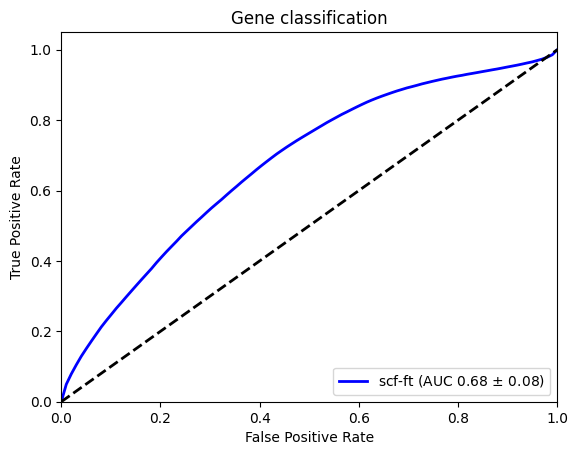

In [14]:
import matplotlib.pyplot as plt

def plot_ROC(bundled_data, title):
    plt.figure()
    lw = 2
    for roc_auc, roc_auc_sd, mean_fpr, mean_tpr, sample, color in bundled_data:
        plt.plot(mean_fpr, mean_tpr, color=color,
                 lw=lw, label="{0} (AUC {1:0.2f} $\pm$ {2:0.2f})".format(sample, roc_auc, roc_auc_sd))
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

bundled_data = [(roc_auc, roc_auc_sd, mean_fpr, mean_tpr, "scf-ft", "blue")]

plot_ROC(bundled_data, 'Gene classification')